Using the CIFAR10 data provided below, create an alogrithm that takes in a gray scale image and coverts it to a color image.

Note for this problem we will define the grayscale image as the average of the three color channels.

In [1]:
from torchvision.datasets import CIFAR10

In [56]:
# imports
import numpy as np
import matplotlib.pyplot as plt

# PyTorch Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
from torchvision.io import read_image
from torchsummary import summary
from torch.utils.data import DataLoader, Dataset
from torchvision import models,transforms, datasets
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter
from torchvision.transforms import Compose, ToTensor, Lambda

%matplotlib inline

"""
from skimage.color import rgb2lab, lab2rgb
from torchvision.datasets import MNIST
from torch.utils.data import data
"""

'\nfrom skimage.color import rgb2lab, lab2rgb\nfrom torchvision.datasets import MNIST\nfrom torch.utils.data import data\n'

Loading CIFAR10 dataset. This holds 10 classes of 32x32 colour images (3 channels)

In [4]:
train_data = CIFAR10(root='./datasets', train=True, download=True, transform=transforms.ToTensor())
test_data = CIFAR10(root='./datasets', train=True, download=False, transform=transforms.ToTensor())

train_loader = DataLoader(train_data,batch_size=64, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_data,batch_size=64, shuffle=False, pin_memory=True)


100%|██████████| 170498071/170498071 [00:04<00:00, 38868789.66it/s]


Extracting ./datasets/cifar-10-python.tar.gz to ./datasets


Visualizing training data

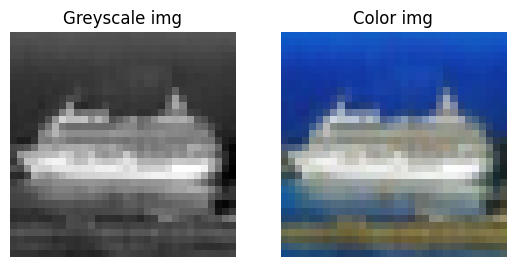

In [7]:
# Visualizing some sample images

figure = plt.figure()

cols, rows = 2, 1
sample_idx = torch.randint(len(train_data), size=(1,)).item()

img, label = train_data[sample_idx]
img_gs = img.mean(dim=0)     # greyscale as avg. over channels (i.e. dim-0)
figure.add_subplot(rows, cols, 1)
plt.title('Greyscale img')
plt.axis("off")
plt.imshow(img_gs.squeeze(), cmap = 'gray')
figure.add_subplot(rows, cols, 2)
plt.title('Color img')
plt.axis("off")
plt.imshow(img.squeeze().permute(1,2,0))
plt.show()


In [8]:
# check if gpu is available
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

We choose to solve this problem using **convolutional Autoencoder**.
The principle behind autoencoders is they consist of an *encoding* network that compresses input data into a lower-dimensional latent space. It then reconstructs input space through a *decoder* network from the latent representation.

The network architecture is as follows :
- Encoding: Network takes 1 channel input. I.e. the greyscale 32x32 image and maps it ti a lower-dimensional latent space representation. We downsample data in the encoder via convolutional layers.
- Latent space: The latent space is a compressed representation of the input image space. The purpose is to capture the essential features and variations in the inout data.
- Decoder: Network attempts to reconstructs the original image from the latent representation. the decoder network learns to invert the encoding process by progressively upsampling and transforming the latent representation back into the original image space.




Here's a brief explanation of the p
- Network takes 1 channel input
- No maxpool layer is added at the encoder step
- Transpose Convolution takes place in decoder step
- Decoder outputs are concatenated with encoder output of the same layer
- Dropout layer added in decoder layer only
- Final layer CNN is the converging layer which outputs 2 channels

In [53]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()

        # encoder layers
        self.en1 = nn.Conv2d(1, 64, 3, stride=1,padding=1)
        self.ebn1 = nn.BatchNorm2d(64)
        self.en2 = nn.Conv2d(64, 64, 3, stride=2,padding=1)
        self.ebn2 = nn.BatchNorm2d(64)
        self.en3 = nn.Conv2d(64, 128, 3,stride=2,padding=1)
        self.ebn3 = nn.BatchNorm2d(128)
        self.en4 = nn.Conv2d(128, 256, 3,stride=2,padding=1)
        #self.ebn4 = nn.BatchNorm1d(256)

        self.pool = nn.MaxPool2d(2, 2)


        self.conv1 = nn.Conv2d(1, 64, 3,stride=1,padding=1)
        self.conv2 = nn.Conv2d(64, 64, 3, stride=2,padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3,stride=2,padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3,stride=2,padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # decoder layers
        self.de1 = nn.ConvTranspose2d(256, 128, 3, stride=2,padding=1,output_padding=1)
        self.dbn1 = nn.BatchNorm2d(128)
        self.de2 = nn.ConvTranspose2d(128, 64, 3, stride=2,padding=1,output_padding=1)
        self.dbn2 = nn.BatchNorm2d(64)
        self.de3 = nn.ConvTranspose2d(64, 64, 3, stride=2,padding=1,output_padding=1)
        self.dbn3 = nn.BatchNorm2d(64)
        self.de4 = nn.ConvTranspose2d(64, 16, 3, stride=1,padding=1)
        self.dbn4 = nn.BatchNorm2d(16)

        self.dropout = nn.Dropout(0.2)
        self.converge = nn.Conv2d(16,3,3,stride=1,padding=1)


        ## decoder layers ##
        self.t_conv1 = nn.ConvTranspose2d(256, 128, 3, stride=2,padding=1,output_padding=1)
        self.t_conv2 = nn.ConvTranspose2d(256, 64, 3, stride=2,padding=1,output_padding=1)
        self.t_conv3 = nn.ConvTranspose2d(128, 128, 3, stride=2,padding=1,output_padding=1)
        self.t_conv4 = nn.ConvTranspose2d(192, 15, 3, stride=1,padding=1)
        self.dropout = nn.Dropout(0.2)
        self.converge = nn.Conv2d(16,3,3,stride=1,padding=1)

    def encoder(self, x):
      x = x.view(-1, 32*32)
      x = F.relu(self.en1(x))
      x = self.ebn1(x)

      x = F.relu(self.en2(x))
      x = self.ebn2(x)

      x = F.relu(self.en3(x))
      x = self.ebn3(x)

      x = F.relu(self.en4(x))
      return x

    def decoder(self, z):
      z = F.relu(self.de1(z))
      z = self.dropout(z)
      z = self.dbn1(z)

      z = F.relu(self.de2(z))
      z = self.dropout(z)
      z = self.dbn2(z)

      z = F.relu(self.de2(z))
      z = self.dropout(z)
      z = self.dbn2(z)

      z = F.relu(self.de3(z))
      z = self.dropout(z)
      z = self.dbn3(z)

      z = F.relu(self.de4(z))
      z = self.dropout(z)
      z = self.dbn4(z)

      Z = F.relu(self.converge(z))
      return z
    """
    def forward(self, x):
      z = self.encoder(x)
      xhat = self.decoder(z)
      #xhat = xhat.view(-1, 3, 32, 32)
      return xhat
    """

    def forward(self, x):
        # encoder
        x = F.relu(self.en1(x))
        x = self.ebn1(x)
        x = F.relu(self.en2(x))
        x = self.ebn2(x)
        x = F.relu(self.en3(x))
        x = self.ebn3(x)
        x = F.relu(self.en4(x))

        # decoder
        xd = F.relu(self.de1(x))
        xd = self.dropout(xd)
        xd = F.relu(self.de2(xd))
        xd = self.dropout(xd)
        xd = F.relu(self.de3(xd))
        xd = self.dropout(xd)
        xd = F.relu(self.de4(xd))
        x_out = F.relu(self.converge(xd))
        return x_out

        """
        x1 = F.relu(self.conv1(x))
        x2 = F.relu(self.conv2(x1))
        x3 = F.relu(self.conv3(x2))
        x4 = F.relu(self.conv4(x3))
        xd = F.relu(self.t_conv1(x4))
        xd = torch.cat((xd, x3), dim=1)
        xd = self.dropout(xd)
        xd = F.relu(self.t_conv2(xd))
        xd = torch.cat((xd, x2), dim=1)
        xd = self.dropout(xd)
        xd = F.relu(self.t_conv3(xd))
        xd = torch.cat((xd, x1), dim=1)
        xd = self.dropout(xd)
        xd = F.relu(self.t_conv4(xd))
        xd = torch.cat((xd, x), dim=1)
        x_out = F.relu(self.converge(xd))
        return x_out
        """


In [54]:
# instantize our model
model = ConvAutoencoder()
model = model.to(device)
summary(model,input_size=(1,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]             640
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 16, 16]          36,928
       BatchNorm2d-4           [-1, 64, 16, 16]             128
            Conv2d-5            [-1, 128, 8, 8]          73,856
       BatchNorm2d-6            [-1, 128, 8, 8]             256
            Conv2d-7            [-1, 256, 4, 4]         295,168
   ConvTranspose2d-8            [-1, 128, 8, 8]         295,040
           Dropout-9            [-1, 128, 8, 8]               0
  ConvTranspose2d-10           [-1, 64, 16, 16]          73,792
          Dropout-11           [-1, 64, 16, 16]               0
  ConvTranspose2d-12           [-1, 64, 32, 32]          36,928
          Dropout-13           [-1, 64, 32, 32]               0
  ConvTranspose2d-14           [-1, 16,


Training: Autoencoders are trained to minimize the difference between the input image and the reconstructed image. This is typically done by using a loss function such as mean squared error (MSE) or binary cross-entropy (BCE) loss. During training, the encoder and decoder networks are jointly optimized to find a compressed latent representation that can effectively reconstruct the input images.

In [ ]:
# some initial choices
EPOCHS = 3
LEARNING_RATE = 1e-4

BATCH_SIZE = 64
Z = 32

# specify loss function
criterion = nn.MSELoss()
# ADAM optimizer
opt = optim.Adam(model.parameters(), lr = LEARNING_RATE)

# training
ls = []

for i in range(EPOCHS):
  total_loss = 0
  print('Epoch: {}'.format(i))

  for j,batch in tqdm(enumerate(train_loader)): # parsing training

    X = batch[0].to(device)

    # we input a greyscale image (mean over channels) to out network
    X_gs = X.mean(1).reshape(-1, 1, 32, 32)

    # parse to model
    Xhat = model(X_gs)

    # note we predict Xhat, i.e. a color image which we compare to full color image X
    loss = F.mse_loss(Xhat, X)

    # for each mini-batch we set gradients to zero
    opt.zero_grad()

    # and performs backwards prop
    loss.backward()
    opt.step()

    # accumulate losses from batch
    total_loss+=loss.item()

  ls.append(total_loss)

# plotting loss-scores
plt.plot(ls)

Epoch: 0


55it [00:37,  1.17it/s]

Visualizing colorization ability on training samples

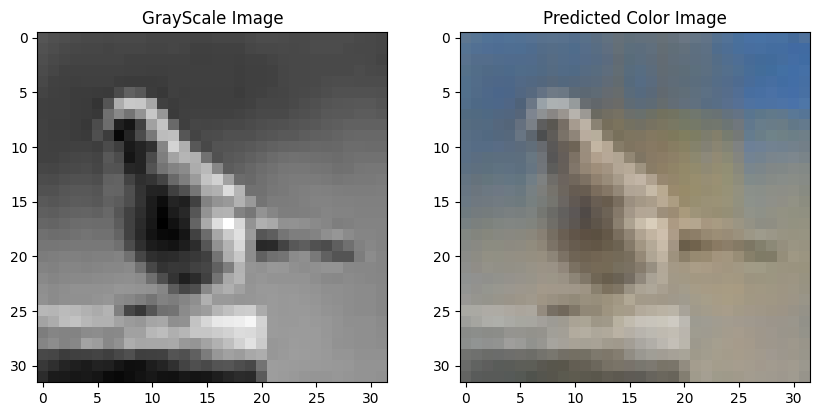

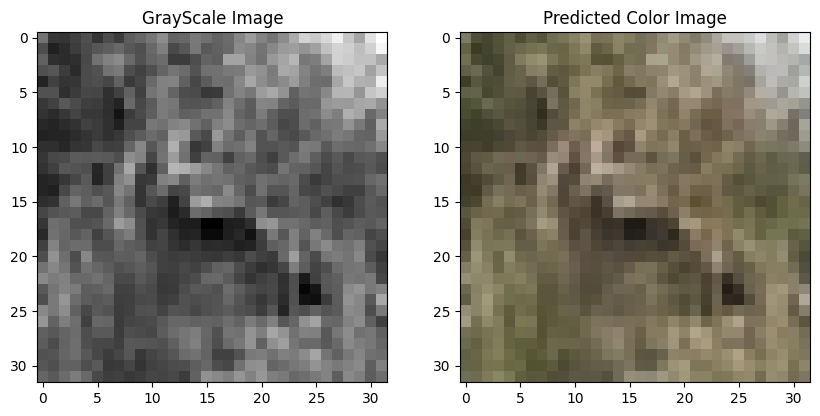

In [ ]:
# training data
i=0
while i<5:
    test_img,test_label = next(iter(train_loader))

    # taking mean over channels to obtain greyscale image
    test_img_gs = test_img[0].cuda().mean(0).reshape(-1, 1, 32, 32)

    # predicts from model by evaluating through feed
    pred = model.forward(test_img_gs)


    fig = plt.figure(figsize=(10,10))
    plt.subplot(221)
    plt.imshow(test_img_gs.cpu().view(32,32),cmap='gray')
    plt.title('GrayScale Image')
    plt.subplot(222)
    plt.imshow(pred.cpu().view(3,32,32).permute(1,2,0).detach().numpy())
    plt.title('Predicted Color Image')
    plt.show()
    i+=1


Visulizing on test data

In [ ]:
# test data
i=0
while i<10:
    test_img,test_label = next(iter(test_loader))

    test_img_gs = test_img[0].cuda().mean(0).reshape(-1, 1, 32, 32)
    pred = model.forward(test_img_gs)

    fig = plt.figure(figsize=(10,10))
    plt.subplot(221)
    plt.imshow(test_img_gs.cpu().view(32,32),cmap='gray')
    plt.title('GrayScale Image')
    plt.subplot(222)
    plt.imshow(pred.cpu().view(3,32,32).permute(1,2,0).detach().numpy())
    plt.title('Predicted Color Image')
    plt.show()
    i+=1